# Superstore Sales & Customer Behavior Analytics with Machine Learning

This notebook performs an end-to-end **retail analytics project** using the popular *Sample - Superstore* dataset.  
It follows a workflow aligned with the **CRISP-DM** methodology:

1. **Business Understanding** – what the Superstore cares about  
2. **Data Understanding** – exploring the dataset  
3. **Data Preparation** – cleaning, transforming, and creating customer-level features  
4. **Modelling** – customer segmentation using **K-Means**  
5. **Evaluation** – interpreting segments and visualising them  
6. **Deployment / Next Steps** – how this analysis can be used in Tableau and in the business

> _Note:_ This version has been restructured and documented for portfolio use (GitHub / LinkedIn / interview).

## 1. Business Understanding

A nationwide retail company called **Superstore** sells office supplies, furniture, and technology products across multiple regions.  
Although sales appear healthy, the management team is concerned about:

- **Low profit margins** in some areas  
- **Uneven performance** across regions, categories, and customer segments  
- Lack of a **data-driven view of customer value and behaviour**  

**High-level business questions**:

- Which products, categories, and regions are **most and least profitable**?  
- Which **customer segments** generate the most value?  
- Are there customers who are at **risk of churn**?  
- How can we use data to **support better decisions** on discounts, stock, and marketing?


## 2. Data Understanding

In this section we:

- Import the required Python libraries  
- Load the **Superstore** dataset  
- Inspect structure, data types, and basic statistics  


In [243]:
# Import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import a tool to scale/standardize numeric features 
from sklearn.preprocessing import StandardScaler
# Import the K-Means algorithm for clustering customers into groups.
from sklearn.cluster import KMeans
# Import a metric that measures how well-separated and well-formed the clusters are.
from sklearn.metrics import silhouette_score


# Load data
df = pd.read_csv("superstore.csv", encoding="latin1")

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### 2.1 Initial inspection

We look at general information about the dataset (columns, data types, missing values) and some descriptive statistics to understand the scale and distribution of the main numeric variables.


In [134]:
# Structure and basic info
df.info()

# Summary statistics for numeric columns
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


Sales range from 0.44 to 22,638, with a very high standard deviation, meaning sales amounts vary a lot between orders.

Quantity per order is usually 3 items, but can go up to 14.

Discount is mostly 0–20%, but can reach 80% in some orders.

Profit ranges from –6,599 to 8,399, showing some orders generate heavy losses, not just small costs.

Large difference between mean and max in Sales and Profit suggests the dataset contains a small number of very large transactions (outliers).


**Business takeaway**

Superstore has highly uneven profitability, with some orders generating strong profit while others — especially heavily discounted ones — cause major financial losses.

### Identify the most profitable product / category

To investigate which items generate the highest financial return, we sort the dataset
by profit in descending order. This reveals the most profitable rows first, helping us
quickly identify top-performing products or categories.


In [137]:
#DataFrame that shows the most profitable product / category
h_product = df.sort_values(['Profit'], ascending= False)

#print the result 
print(h_product.head(10))


      Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
6826    6827  CA-2016-118689   10/2/2016   10/9/2016  Standard Class   
8153    8154  CA-2017-140151   3/23/2017   3/25/2017     First Class   
4190    4191  CA-2017-166709  11/17/2017  11/22/2017  Standard Class   
9039    9040  CA-2016-117121  12/17/2016  12/21/2016  Standard Class   
4098    4099  CA-2014-116904   9/23/2014   9/28/2014  Standard Class   
2623    2624  CA-2017-127180  10/22/2017  10/24/2017     First Class   
509      510  CA-2015-145352   3/16/2015   3/22/2015  Standard Class   
8488    8489  CA-2016-158841    2/2/2016    2/4/2016    Second Class   
7666    7667  US-2016-140158   10/4/2016   10/8/2016  Standard Class   
6520    6521  CA-2017-138289   1/16/2017   1/18/2017    Second Class   

     Customer ID         Customer Name      Segment        Country  \
6826    TC-20980          Tamara Chand    Corporate  United States   
8153    RB-19360          Raymond Buch     Consumer  United States 

**Result Interpretation:**  
The resulting DataFrame (`h_product`) displays the transactions ordered from highest
profit to lowest. Inspecting the top rows allows us to determine which products or
categories contribute most to profitability, which is useful for prioritising inventory,
marketing, and promotional strategies.


### Visualize Sales & Profit by Product Category

This visual explores which product categories generate the highest sales and the highest profit.
Comparing both metrics side-by-side helps reveal whether strong revenue also translates into strong
profitability, or whether certain categories may be over-discounted or low-margin.


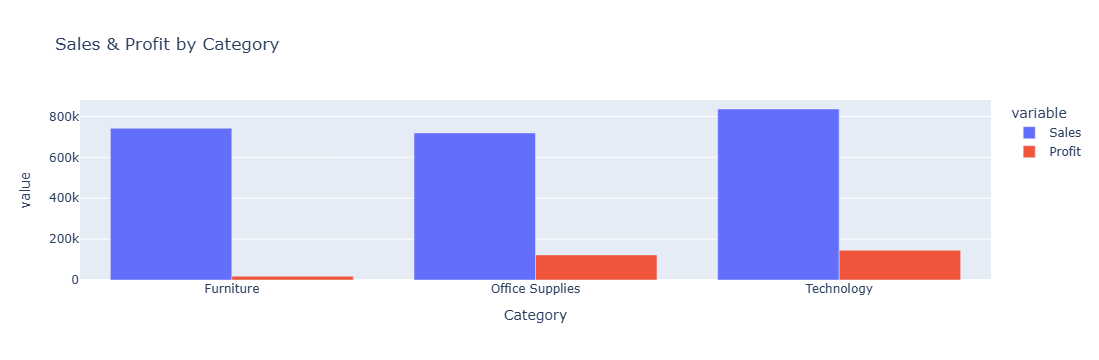

In [205]:
#Import the necessary libraries
import plotly.express as px

# Group the data by product category and calculate total sales and total profit for each category,
# then convert the result back to a clean DataFrame.
category_sales = df.groupby("Category")[["Sales", "Profit"]].sum().reset_index()

# Create a grouped bar chart comparing Sales vs Profit across each product category.
fig = px.bar(
    category_sales,
    x="Category",
    y=["Sales", "Profit"],
    barmode="group",
    title="Sales & Profit by Category"
)
fig.show()


**Result Interpretation:**  
The grouped bar chart displays the total Sales and total Profit for each product category
(Furniture, Office Supplies, and Technology). If a category shows high sales but weak profit,
this may indicate issues such as heavy discounting or low margin. Categories that rank high
in both sales and profit represent strong business opportunities and should be prioritised
for inventory allocation and marketing focus. In this case "Technology" has the most profit compare to the other two.


### Sales & Profit by Product Category

This visual explores which product categories generate the highest sales and the highest profit.
Comparing both metrics side-by-side helps reveal whether strong revenue also translates into strong
profitability, or whether certain categories may be over-discounted or low-margin.



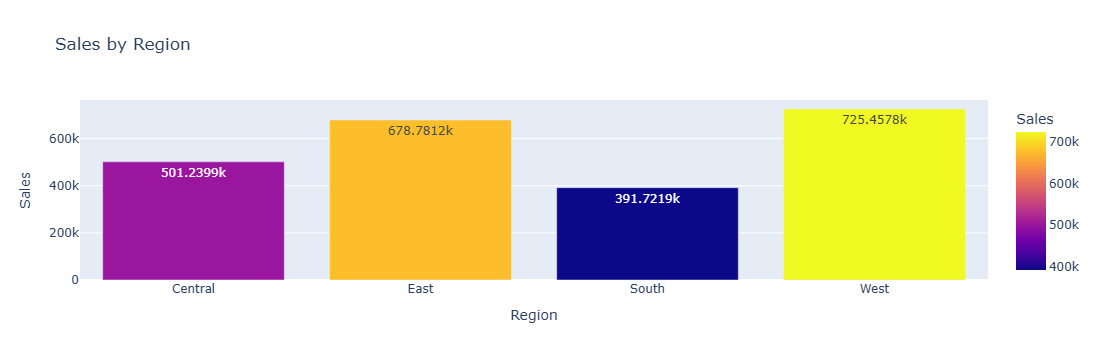

In [200]:
# Group the data by region and calculate the total sales for each region.
region_sales = df.groupby("Region")["Sales"].sum().reset_index()

# Create a bar chart showing how much each region contributes to total sales.
fig = px.bar(
    region_sales,
    x="Region",
    y="Sales",
    title="Sales by Region",
    color="Sales",
    text_auto=True
)
fig.show()


**Result Interpretation:**  
The grouped bar chart displays the total Sales and total Profit for each product category
(Furniture, Office Supplies, and Technology). If a category shows high sales but weak profit,
this may indicate issues such as heavy discounting or low margin. Categories that rank high
in both sales and profit represent strong business opportunities and should be prioritised
for inventory allocation and marketing focus.


###  Top 10 Most Profitable Sub-Categories

To drill deeper into profitability beyond broad product categories, this visual identifies
the top 10 sub-categories ranked by total profit. This provides clear insight into which
specific product types generate the highest financial return and therefore deserve priority
in stocking, promotion, and strategic planning.


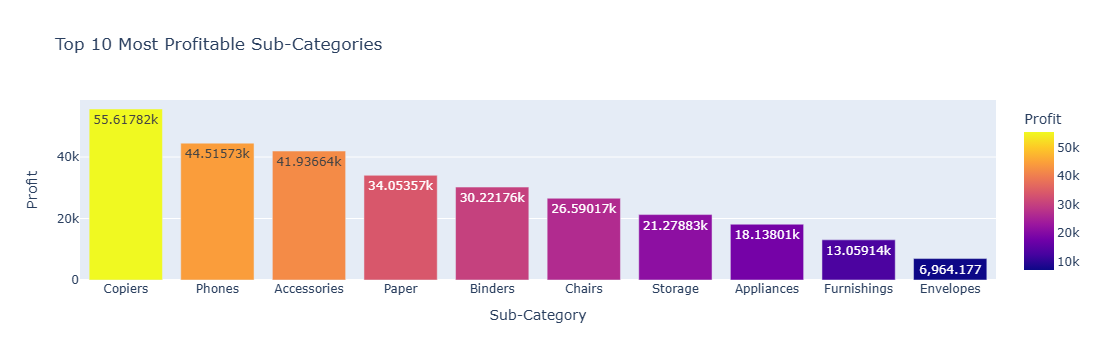

In [198]:
# Group data by sub-category and sum the total profit for each,
# sort them from highest to lowest profit,
# select the top 10 most profitable sub-categories,
# and convert the result back into a clean DataFrame.
top_profit_sub = (
    df.groupby("Sub-Category")["Profit"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Create a bar chart showing the 10 sub-categories with the highest total profit.
fig = px.bar(
    top_profit_sub,
    x="Sub-Category",
    y="Profit",
    title="Top 10 Most Profitable Sub-Categories",
    text_auto=True,
    color="Profit"
)
fig.show()


**Result Interpretation:**  
The bar chart presents the most profitable 10 sub-categories, ordered from highest to lowest.
Sub-categories at the top represent major profit drivers for the business and should be
considered for marketing attention, cross-selling opportunities, and optimized inventory
levels. Lower items on the list, even if still profitable, can be reviewed for potential
growth strategies or bundled promotions.


In [152]:
top_profit_sub


,Sub-Category,Profit
0,Copiers,55617.8249
1,Phones,44515.7306
2,Accessories,41936.6357
3,Paper,34053.5693
4,Binders,30221.7633
5,Chairs,26590.1663
6,Storage,21278.8264
7,Appliances,18138.0054
8,Furnishings,13059.1436
9,Envelopes,6964.1767


**Result Interpretation (based on output):**  
- **Copiers** is by far the most profitable sub-category, significantly outperforming all others.  
- **Phones** and **Accessories** also generate very strong profit, forming the second and third largest contributors.  
- **Paper** and **Binders** sit in the middle of the ranking — consistently profitable but not standout performers.  
- **Envelopes** ranks lowest within the top 10, indicating it contributes profit but far less compared to categories like Copiers and Phones.

**Business Insight:**  
Profit performance is heavily concentrated in a small number of sub-categories. Superstore can maximise revenue growth by prioritising inventory, sales focus, and promotional activity on **Copiers, Phones, and Accessories**, while exploring pricing or bundling strategies to increase returns from **mid-ranked sub-categories such as Paper and Binders**.


### Monthly Sales Trend

This line chart shows how total sales change month-to-month across the timeline of the dataset.
Identifying sales peaks and drops helps the business understand seasonality and high-demand periods.


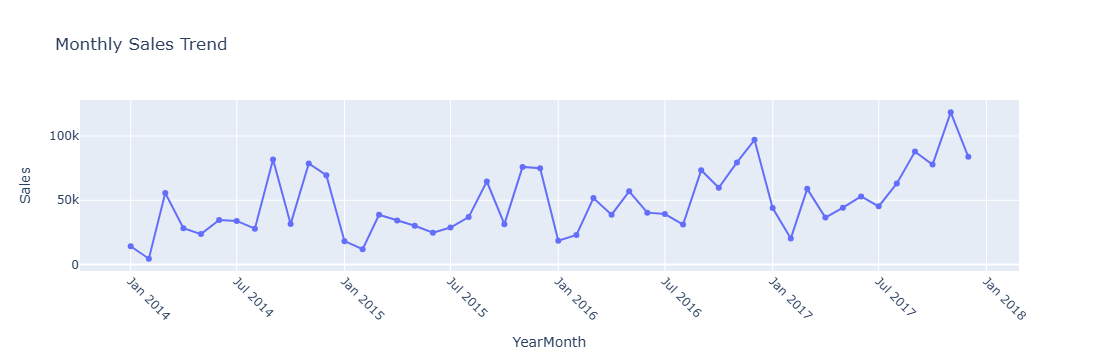

In [196]:
# Convert the Order Date column to proper datetime format.
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Extract the year and month (YYYY-MM) from each order date and store it as a new column.
df["YearMonth"] = df["Order Date"].dt.to_period("M").astype(str)

# Group the data by Year-Month and calculate the total sales for each month.
monthly_sales = df.groupby("YearMonth")["Sales"].sum().reset_index()

# Create a line chart showing how total sales change month by month,
# with markers added to highlight each monthly value.
fig = px.line(
    monthly_sales,
    x="YearMonth",
    y="Sales",
    title="Monthly Sales Trend",
    markers=True
)
# Rotate x-axis labels so they don’t overlap and remain readable.
fig.update_xaxes(tickangle=45)

# Display the final visualization.
fig.show()


**Result Interpretation:**  
- Sales fluctuate noticeably across months rather than staying stable.  
- Months showing clear peaks represent **strong seasonal demand**, while lower periods indicate **slow sales cycles**.  
- If peak months cluster around the same time each year, this suggests **predictable seasonality**, which can support smarter inventory planning and promotional scheduling.


**Based on chart:**  
- Sales show a **clear repeating seasonal pattern**, with noticeable peaks toward the **end of each year (around Nov–Dec)**.  
- The lowest sales periods consistently occur in the **early months of the year (Jan–Feb)**.  
- Overall, there is a **gradual upward trend across the 4-year period**, indicating business growth over time rather than stagnation.
- A particularly strong surge appears in **late 2017**, marking the highest sales point in the dataset.

**Business Insight:**  
Understanding the monthly sales pattern allows Superstore to allocate stock, workforce, and marketing budget more efficiently — increasing focus during historically high-demand months and running promotions to prevent slow-period drop-offs.
Superstore should prepare **higher inventory, staffing, and marketing promotions during November–December**, when customer spending is historically the strongest.  
Campaigns and discount strategies may be useful during **January–February** to prevent revenue slowdown during the weakest months.


### Profitability by City — Top 15 vs Bottom 15

To understand how profitability varies across geographic markets, total profit was aggregated
at the city level. This allows us to identify the strongest and weakest performing locations,
which supports targeted regional planning rather than blanket decision-making.


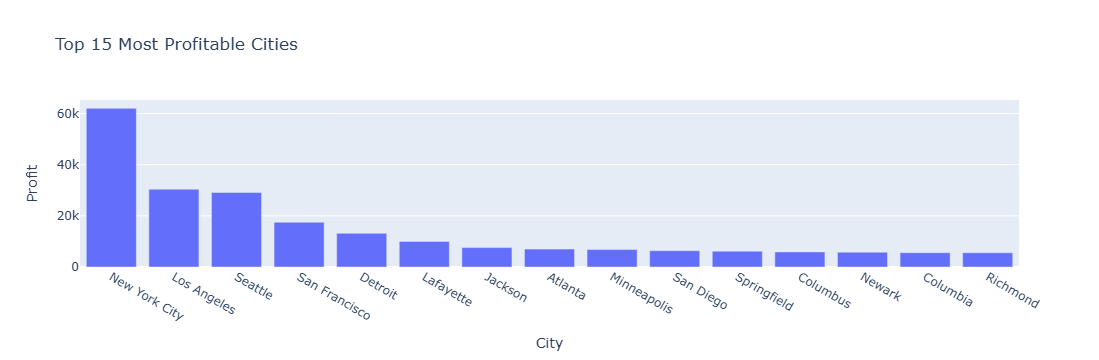

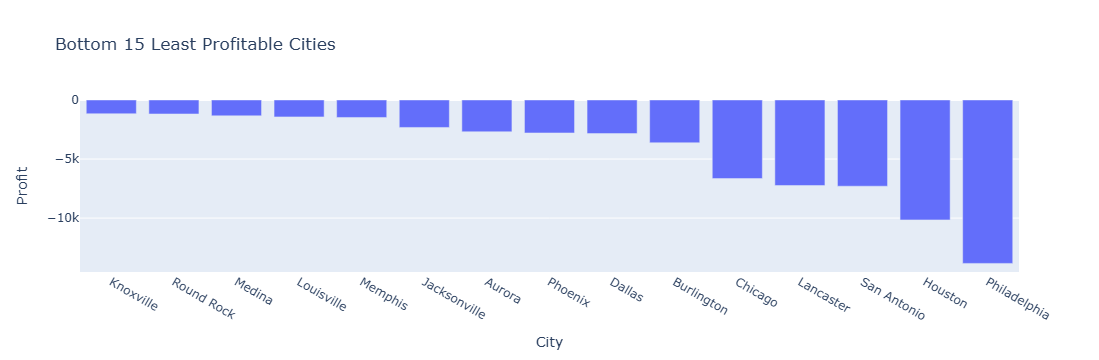

In [194]:
# Group the data by city, calculate total profit per city,
# then sort cities from highest to lowest profit.
city_profit = (
    df.groupby("City")["Profit"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Create a bar chart showing the 15 cities with the highest total profit.
fig = px.bar(
    city_profit.head(15),
    x="City",
    y="Profit",
    title="Top 15 Most Profitable Cities"
)
fig.show()

# Create a bar chart showing the 15 cities with the lowest (or negative) total profit.
fig = px.bar(
    city_profit.tail(15),
    x="City",
    y="Profit",
    title="Bottom 15 Least Profitable Cities"
)
fig.show()


**Result Interpretation (based on chart):**  
- **New York City is by far the most profitable city**, generating more than **double the profit** of the next strongest markets.
- Other high-profit cities include **Los Angeles, Seattle, and San Francisco**, showing that the West Coast and major metro areas play a critical role in Superstore’s revenue and margin performance.
- On the opposite end, **Philadelphia and Houston show the highest losses** — Philly is the worst performer by a large margin, followed by Houston.
- Multiple other cities — **San Antonio, Lancaster, Chicago, Burlington, and Dallas** — also produce **negative total profit**, not just low profit.

**Business Insight:**  
Profitability is **not evenly distributed across regions** — a small number of cities produce large profit while several others consistently lose money.  
Strategic recommendations:

🔹 **Prioritise inventory, promotions, and faster delivery in NYC, LA, Seattle and other profitable locations.**  
🔹 **Investigate unprofitable cities individually** — losses may be caused by discount dependence, inefficient shipping costs, or product fit.  
🔹 **A uniform pricing and marketing strategy is sub-optimal**; cities should receive **localized strategies** based on their profitability profile.


### Seasonal Sales Pattern by Month

To explore whether sales follow a recurring seasonal pattern across the calendar year,
total sales were aggregated by month (1–12). This helps identify which months naturally
drive the highest spending and which represent slower periods.


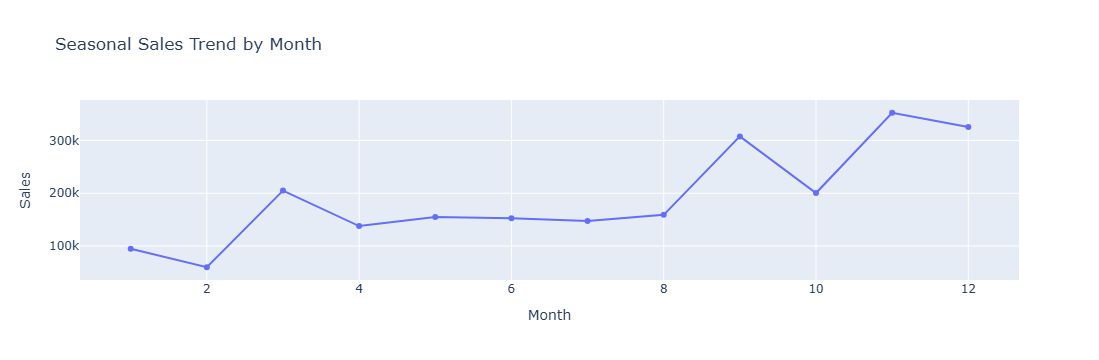

In [165]:
# Extract the month number (1–12) from each Order Date and store it in a new column.
df["Month"] = df["Order Date"].dt.month

# Group the data by month and calculate the total sales for each month.
seasonal_sales = df.groupby("Month")["Sales"].sum().reset_index()

# Create a line chart showing how sales change across months,
# with markers added to highlight each point.
fig = px.line(
    seasonal_sales,
    x="Month",
    y="Sales",
    markers=True,
    title="Seasonal Sales Trend by Month"
)
fig.show()


**Result Interpretation (based on chart):**  
- Sales peak in **November and December**, confirming a strong holiday-driven demand pattern.  
- Sales drop to their lowest levels in **January and February**, making these the weakest commercial months of the year.  
- Mid-year sales (April–August) remain **moderate and more stable**, without extreme peaks or drops.

**Business Insight:**  
Superstore should **boost inventory and marketing** during November–December to maximize revenue during the strongest shopping season.  
Conversely, **January–February require strategies to prevent turnover decline**, such as clearance discounts or promotional bundles to counter post-holiday slowdowns.


### Product Demand vs Profit (Bubble Chart)

This scatter plot compares total **Quantity sold** (demand) against **Profit** for each sub-category.
Bubble size represents **total Sales**, and colour identifies each sub-category.  
This helps determine whether high product demand truly translates into high profitability.


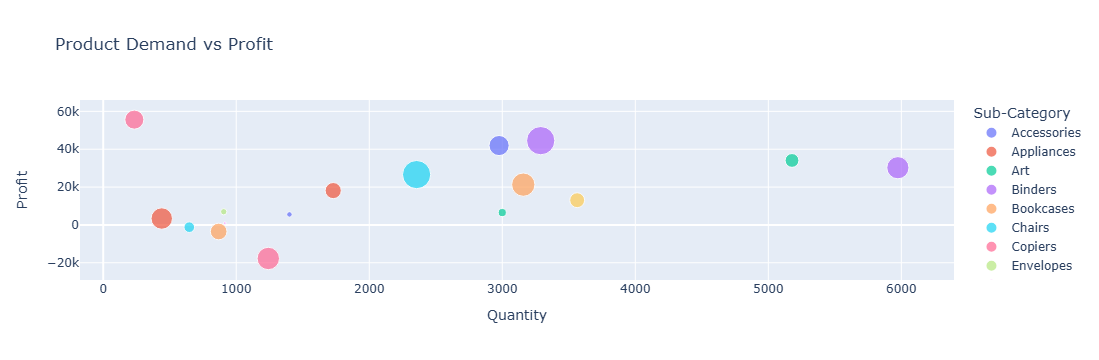

In [169]:
# Group data by Sub-Category and calculate total Sales, total Quantity sold,
# and total Profit for each sub-category.
product_demand = df.groupby("Sub-Category").agg({
    "Sales": "sum",
    "Quantity": "sum",
    "Profit": "sum"
}).reset_index()

# Create a scatter plot where each point represents a sub-category:
fig = px.scatter(
    product_demand,
    x="Quantity",
    y="Profit",
    size="Sales",
    color="Sub-Category",
    title="Product Demand vs Profit"
)
fig.show()


**Result Interpretation (based on chart):**  
- **Tables** have **very low demand but extremely high profit**, meaning even a small number of sales generates a large margin — a premium product line.
- **Phones** show **very high demand and very high profit**, making them the strongest and most stable revenue driver.
- **Paper** has **high demand and high profit**, proving it is a consistent high-volume and high-margin seller.
- **Supplies** have **moderate demand and strong profit**, indicating an efficient product line.
- **Storage and Furnishings** both show **high demand but only moderate profit**, suggesting margin pressure or competitive pricing.
- **Fasteners and Machines** show **very low demand and low/negative profit**, signalling weak commercial performance or over-discounting.
- **Labels** are **low demand but positive profit**, acting as a niche but financially healthy category.

**Business Insight:**  
- **Phones and Paper should be prioritised** for inventory, marketing campaigns, and faster delivery guarantees — they are the safest revenue engines.
- **Tables deserve premium positioning**, NOT discounts — they generate high profit even with low demand.
- **Storage and Furnishings need margin optimisation** (reduce discounts, revise pricing) rather than more advertising.
- **Fasteners and Machines require intervention** — either reposition, bundle, or consider phasing out if profitability cannot be improved.


### 2.2 Pair plot of core numeric variables

Before doing any feature engineering, we examine pairwise relationships between key numeric fields such as `Sales`, `Profit`, `Quantity`, `Discount`, and (if available) `Shipping Cost`. This helps us visually check:

- How sales relate to profit  
- How discount levels affect profit  
- Whether there are non-linear relationships or clusters


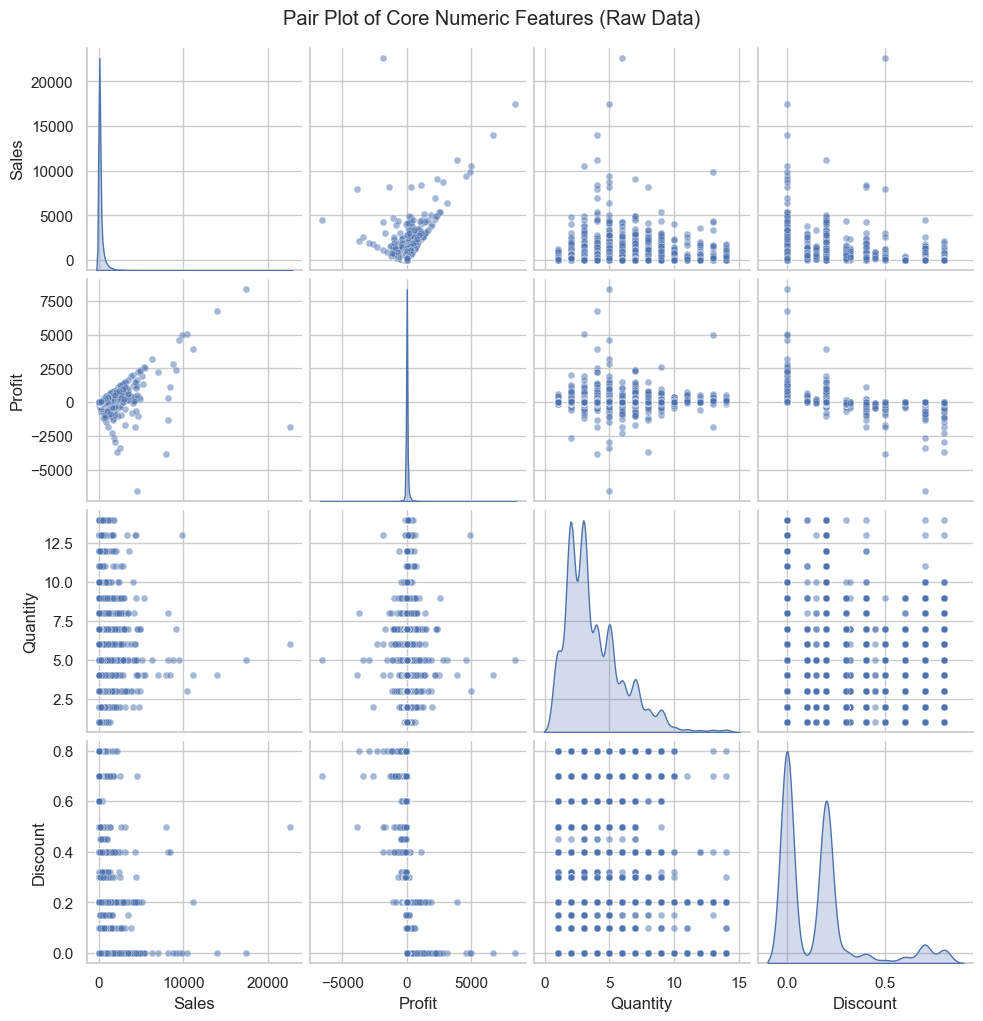

In [173]:
# Create a list of the numeric columns we want to analyze.
numeric_cols =  ["Sales", "Profit", "Quantity", "Discount"] 

# Generate pair plots to show relationships between every pair of numeric features,
# using KDE curves on the diagonal and scatter plots on the rest.
sns.pairplot(df[numeric_cols], diag_kind="kde", plot_kws={"alpha": 0.5, "s": 25})

# Add a title slightly above the plot so it doesn’t overlap the figure.
plt.suptitle("Pair Plot of Core Numeric Features (Raw Data)", y=1.02)

# Display the final visualization.
plt.show()

**Result Interpretation (based on pair-plot):**
- **Sales and Profit are positively correlated** — higher sales usually lead to higher profit, but there are several points where high sales correspond to **negative profit**, indicating heavy discount losses or unprofitable pricing.
- **Discount and Profit show a clear negative pattern** — as discount increases, profit generally drops, confirming that discounting has a strong negative impact on margins.
- **Quantity does not strongly correlate with Profit or Sales** — high order quantities do not necessarily translate into high revenue or high profit. Some small-quantity orders generate much higher profit than bulk-quantity orders.
- The **distribution of Discount is highly clustered at 0% and 50%** — suggesting two primary pricing modes (full price vs half-price promotions), which likely explains the large swings in profit.
- **Profit distribution is wide**, with many transactions near zero but a noticeable cluster of steep negative values — meaning too many orders operate at a loss.

**Business Insight:**
Pricing strategy and discount rules have a much bigger impact on profit than product demand or quantity ordered.  
To protect margin, Superstore should:
- reduce blanket 50% discount promotions,
- re-evaluate loss-making SKUs,
- apply targeted discounts rather than broad price cuts.


### 2.3 Correlation heatmap

To complement the pair plot, we compute a correlation matrix between the same numeric features. This gives a compact view of linear relationships (e.g., negative correlation between high discounts and profit).


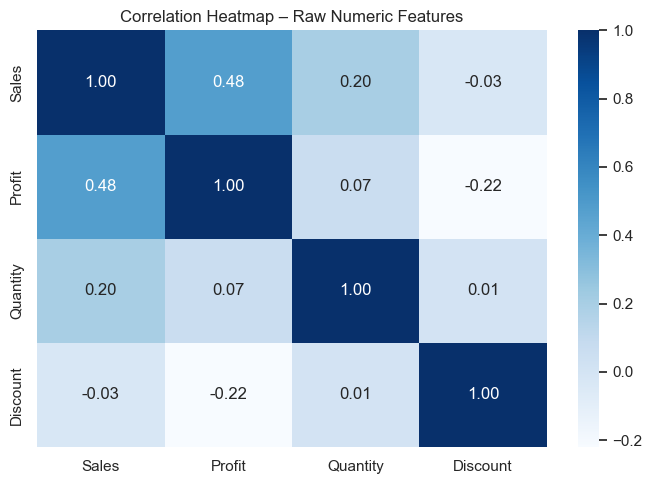

In [176]:
# Set the size of the heatmap figure 
plt.figure(figsize=(7, 5))

# Calculate the correlation matrix for the selected numeric columns.
corr = df[numeric_cols].corr()

# Plot the heatmap with
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation Heatmap – Raw Numeric Features")
plt.tight_layout()
plt.show()

**Result Interpretation (based on correlation heatmap):**
- **Sales and Profit have a moderate positive correlation (0.48)** — higher sales generally lead to higher profit, but not strongly enough to guarantee profitability.
- **Profit and Discount have a clear negative correlation (-0.22)** — the more discount applied, the lower the profit. This confirms that discounting directly erodes margins.
- **Sales and Discount show almost no correlation (-0.03)** — discounts do not reliably increase sales volume, meaning promotions are not driving extra revenue.
- **Quantity has weak correlations with all other features (≤ 0.20)** — increasing quantity alone does not drive sales or profit. High-order volume is not the primary success factor.

**Business Insight:**
Profitability is driven more by **pricing discipline than sales volume**.  
The heatmap clearly shows that:
- aggressive discounting reduces margin without meaningfully increasing sales,
- product-level pricing strategy is more valuable than pushing high quantity orders,
- identifying and correcting loss-making pricing or promotions would substantially improve total profit.


## 3.1 Data Preparation – Data Quality(Null)**

Check for Null Data 

In [207]:
#Verify Data Quality
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
YearMonth        0
Month            0
dtype: int64

**No Null in dataframe**

**3.2 Data Preparation – Data Quality (Duplicated)**

Check for duplicated data

In [227]:
#Determine if Data Dupplicated
df[df.duplicated()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,YearMonth,Month


**No Duplicated Row**

## 3.3 Data Preparation – Customer-level Features (RFM)

For customer segmentation, we move from the **transaction level** (each row = order line) to the **customer level**.  
We engineer classic **RFM**-style features plus average discount:

- **Recency** – how many days since the customer’s last purchase (lower = more recent / engaged)  
- **Frequency** – how many unique orders the customer has placed  
- **Monetary** – total sales value per customer  
- **AvgDiscount** – average discount received, as a proxy for price sensitivity  


In [180]:
# Ensure Order Date is a datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])  # Convert the Order Date column into proper datetime format.

# Define a snapshot date (the day after the last order in the dataset)
snapshot_date = df["Order Date"].max() + pd.Timedelta(days=1)  # Set a reference date equal to one day after the most recent order in the dataset.

# Aggregate to customer-level features
customer_features = df.groupby("Customer ID").agg({
    "Order Date": lambda x: (snapshot_date - x.max()).days,  # Recency: days since last purchase
    "Order ID": "nunique",                                   # Frequency: number of unique orders
    "Sales": "sum",                                          # Monetary: total spend
    "Discount": "mean"                                       # AvgDiscount: mean discount
})

customer_features.columns = ["Recency", "Frequency", "Monetary", "AvgDiscount"]
customer_features.head()

,Recency,Frequency,Monetary,AvgDiscount
Customer ID,,,,
AA-10315,185,5,5563.560,0.090909
AA-10375,20,9,1056.390,0.080000
AA-10480,260,4,1790.512,0.016667
AA-10645,56,6,5086.935,0.063889
AB-10015,416,3,886.156,0.066667


### 3.1 Visualising customer-level features

Before clustering, we explore how **Recency**, **Frequency**, **Monetary**, and **AvgDiscount** relate to each other using a pair plot and a correlation heatmap at the customer level.


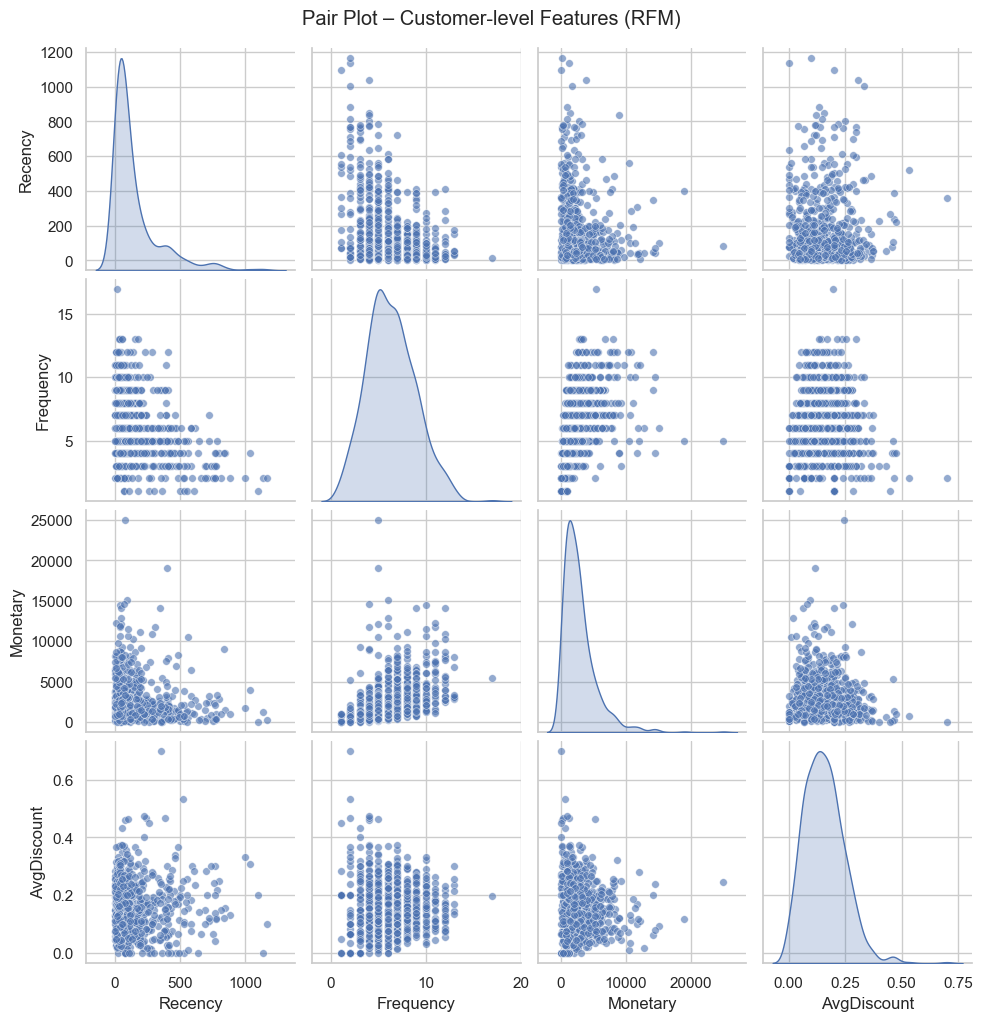

In [188]:
#Visualize using pairplot
sns.pairplot(
    customer_features[["Recency", "Frequency", "Monetary", "AvgDiscount"]],
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 30}
)

plt.suptitle("Pair Plot – Customer-level Features (RFM)", y=1.02)
plt.show()



**Result Interpretation (based on RFM pair plot):**
- **Recency vs Frequency:** Customers who buy more often tend to have **lower recency (recent purchases)** — frequent shoppers churn less.
- **Recency vs Monetary:** High-spending customers usually purchase **recently**, meaning your most valuable customers are still active.
- **Frequency vs Monetary:** Higher frequency generally leads to higher monetary value — repeat buyers contribute the most revenue.
- **AvgDiscount vs Profit Drivers:** Customers with **higher average discounts do not show better buying frequency or monetary value**, meaning discounts are not creating loyal high-value customers.

**Business Insight:**  
The best customers (high-frequency + high-monetary + low-recency) are still active — a strong sign of retention without heavy discounting.  
The **discount-driven customers are not your highest spenders**, so Superstore should **avoid relying on discounts to build loyalty** and instead focus on customer experience and product value.


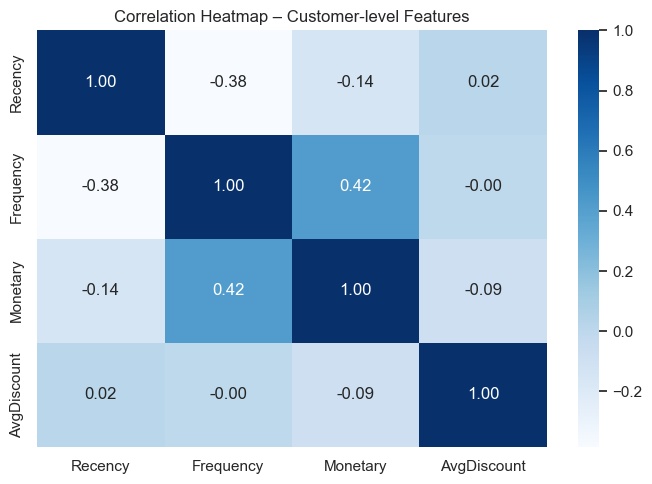

In [185]:
#Plot the heatmap
plt.figure(figsize=(7, 5))

sns.heatmap(customer_features.corr(), annot=True, fmt=".2f", cmap="Blues")

plt.title("Correlation Heatmap – Customer-level Features")
plt.tight_layout()
plt.show()

**Result Interpretation (based on RFM correlation heatmap):**
- **Recency and Frequency have a moderate negative correlation (-0.38)** — customers who purchase frequently tend to buy more recently, confirming lower churn risk among repeat buyers.
- **Frequency and Monetary have a strong positive correlation (0.42)** — customers who order more often also spend more, meaning repeat buyers are the main revenue contributors.
- **Recency and Monetary show a weak negative correlation (-0.14)** — high-spending customers are slightly more likely to make recent purchases.
- **AvgDiscount has almost zero correlation with Recency, Frequency, or Monetary** — discounts do **not** improve customer loyalty, retention, or total spending.

**Business Insight:**
Customer value is driven by **repeat purchase behavior, not discounts**.  
The heatmap clearly indicates that:
- **high-frequency customers are the strongest revenue drivers and stay active**,  
- **price promotions do not meaningfully influence customer loyalty**,  
so retention strategy should focus on **experience, convenience, and loyalty rewards**, not heavier discounting.


## 4. Modelling – Customer Segmentation with K-Means

We now build a **K-Means clustering** model to segment customers based on the RFM + discount features.

Steps:

1. **Scale** the features (K-Means is distance-based, so scaling is important).  
2. Use the **Elbow method** to inspect inertia (within-cluster sum of squares) for different `k`.  
3. Use the **Silhouette score** to assess how well-defined the clusters are.  
4. Fit the final K-Means model and assign each customer to a cluster/segment.


In [36]:
# Select the four RFM features and create a separate dataset for modeling.
X = customer_features[["Recency", "Frequency", "Monetary", "AvgDiscount"]].copy()

# Create a scaler object that will standardize the data (mean = 0, std = 1).
scaler = StandardScaler()
# Apply scaling to the selected features so they are all on the same scale.
X_scaled = scaler.fit_transform(X)

### 4.1 Choosing the number of clusters (Elbow & Silhouette)

We evaluate `k` from 2 to 8 using both:

- **Elbow method** – looks at how inertia decreases with more clusters  
- **Silhouette score** – measures how well-separated the clusters are (higher is better, max = 1)


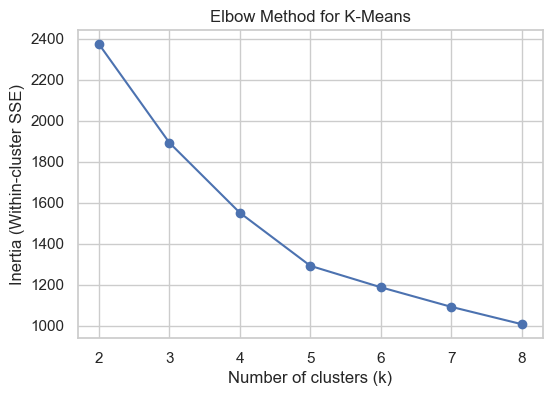

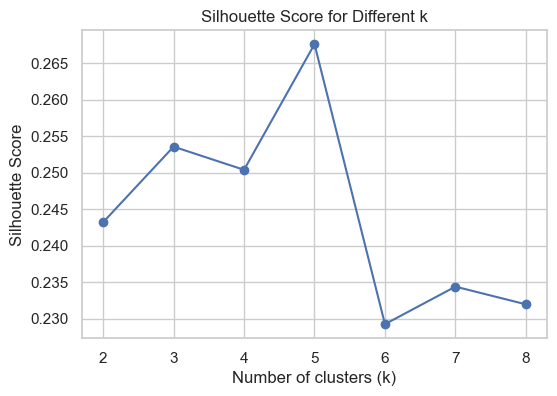

[(2, 0.2431976247300125),
 (3, 0.2535493297551828),
 (4, 0.2503753465497592),
 (5, 0.2675843737476711),
 (6, 0.22923769300265126),
 (7, 0.23437922688698354),
 (8, 0.2319548104167452)]

In [61]:
# Create empty lists to store evaluation metrics and define k values (2–8) to test.
inertia = []
silhouette_scores = []
K_range = range(2, 9)

# For each k value:
#   build a K-Means model
#   assign cluster labels
#   store inertia (cluster tightness) and silhouette score (cluster separation)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot the Elbow curve showing how inertia changes as k increases
# (helps identify the best number of clusters).
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

# Plot silhouette scores for each k to validate cluster separation quality
# (higher silhouette score = better clustering).
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.grid(True)
plt.show()

# Combine each k value with its corresponding silhouette score into pairs, so you can easily see which number of clusters gives the best score.
list(zip(K_range, silhouette_scores))

### 4.2 Fit final K-Means model

Based on the Elbow and Silhouette analysis, we choose a reasonable value of `k` (for example, **k = 5**).  
> You can adjust `k` below if your analysis suggests a different optimal value.


In [42]:
 # Adjust this if your Elbow/Silhouette analysis suggests another value
k = 5 
# Create the final K-Means model using the chosen number of clusters (k).
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the K-Means model on the scaled data and assign the resulting cluster label
customer_features["Cluster"] = kmeans_final.fit_predict(X_scaled)

customer_features.head()

,Recency,Frequency,Monetary,AvgDiscount,Cluster
Customer ID,,,,,
AA-10315,185,5,5563.560,0.090909,0
AA-10375,20,9,1056.390,0.080000,2
AA-10480,260,4,1790.512,0.016667,0
AA-10645,56,6,5086.935,0.063889,0
AB-10015,416,3,886.156,0.066667,3


### 4.3 Visualising clusters 

To understand the segmentation, we visualise clusters in 2D projections of:

- **Frequency vs Monetary** – who are the high-value / loyal customers?  
- **Recency vs Monetary** – which clusters look at risk of churn?  


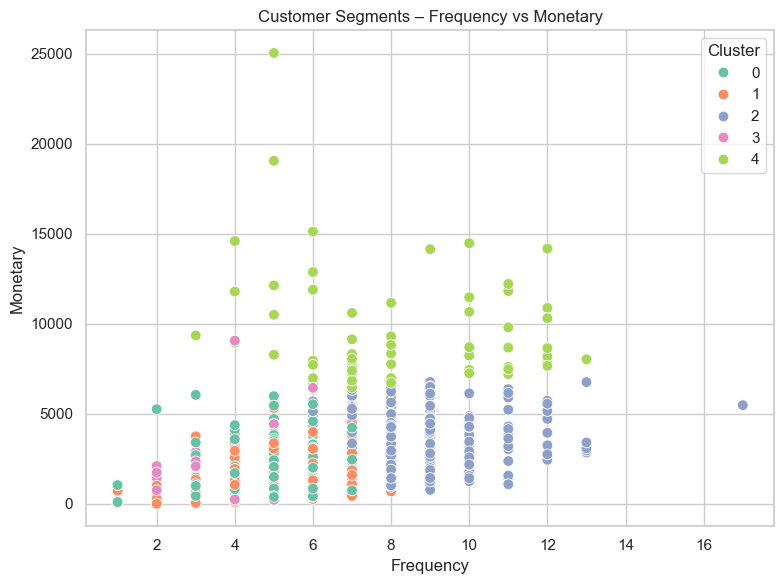

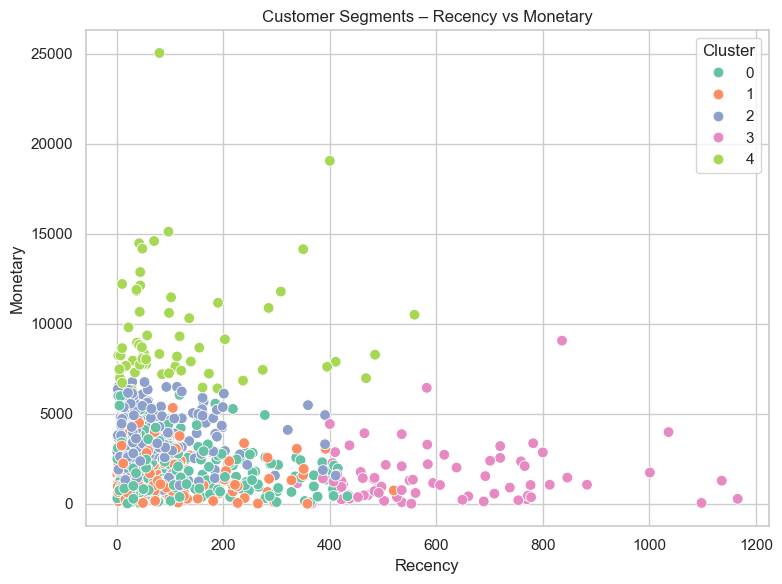

In [45]:
# Set the size of the first scatter plot.
plt.figure(figsize=(8, 6))

# Create a scatter plot showing customer segments based on Frequency 
sns.scatterplot(
    data=customer_features,
    x="Frequency",
    y="Monetary",
    hue="Cluster",
    palette="Set2",
    s=60
)
plt.title("Customer Segments – Frequency vs Monetary")
plt.tight_layout()
plt.show()

# Set the size of the second scatter plot.
plt.figure(figsize=(8, 6))

# Create a second scatter plot showing customer segments based on Recency
sns.scatterplot(
    data=customer_features,
    x="Recency",
    y="Monetary",
    hue="Cluster",
    palette="Set2",
    s=60
)
plt.title("Customer Segments – Recency vs Monetary")
plt.tight_layout()
plt.show()

## 5. Evaluation & Segment Interpretation

We summarise average **Recency**, **Frequency**, **Monetary**, and **AvgDiscount** by cluster to interpret each segment in business terms (e.g., VIP, at-risk, bargain hunters).


In [48]:
#Group customers based on the cluster they belong to.
cluster_summary = customer_features.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "sum"],
    "AvgDiscount": "mean"
})

cluster_summary

Recency Frequency     Monetary              AvgDiscount
               mean      mean         mean          sum        mean
Cluster                                                            
0        117.370968  4.959677  1871.552372  464144.9883    0.088772
1        105.283871  5.012903  1601.467561  248227.4719    0.265356
2         73.015748  8.814961  3476.129621  882936.9238    0.160154
3        607.666667  3.533333  1538.344449  115375.8337    0.172111
4        125.557377  8.163934  9615.010534  586515.6426    0.133608

### 5.1 (Optional) Assign human-readable segment names

Based on the summary statistics, we can map each numeric cluster to a descriptive label, such as:

- **VIP / Loyal** – low Recency, high Frequency, high Monetary  
- **At Risk** – high Recency, low Frequency, low Monetary  
- **High Potential** – relatively new but high Monetary or Frequency  
- **Bargain Buyers** – lower Monetary but high discount usage  

You may adjust the mapping after inspecting `cluster_summary`.


In [51]:
# Create a dictionary that assigns a readable name to each cluster number.
segment_names = {
    0: "Segment 0",
    1: "Segment 1",
    2: "Segment 2",
    3: "Segment 3",
    4: "Segment 4",
}

## Create a new column that replaces each cluster number with its segment name using the dictionary
customer_features["SegmentName"] = customer_features["Cluster"].map(segment_names)

customer_features.head()

,Recency,Frequency,Monetary,AvgDiscount,Cluster,SegmentName
Customer ID,,,,,,
AA-10315,185,5,5563.560,0.090909,0,Segment 0
AA-10375,20,9,1056.390,0.080000,2,Segment 2
AA-10480,260,4,1790.512,0.016667,0,Segment 0
AA-10645,56,6,5086.935,0.063889,0,Segment 0
AB-10015,416,3,886.156,0.066667,3,Segment 3


## 6. Deployment – Export segmented dataset for Tableau

To build an interactive dashboard, we join the customer-level segments back to the original transaction dataset and export the result as a CSV file.


In [54]:
#Merge the original dataset df with the customer segmentation results.
df_segments = df.merge(
    customer_features[["SegmentName"]],
    left_on="Customer ID",
    right_index=True,
    how="left"
)

# Define the name of the exported file.
output_path = "Superstore_Final_with_Segments.csv"
# Export the full dataset (now including segment labels) as a CSV without index numbers.
df_segments.to_csv(output_path, index=False)

# Display the file name to confirm where the exported file has been saved.
output_path

'Superstore_Final_with_Segments.csv'